# `linreg-manual`

Task: fit a linear regression using gradient descent, with gradients computed by backpropagation using PyTorch

## Setup

In [1]:
import torch
from torch import tensor
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Task

Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

In [2]:
import pandas as pd
data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
data.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.16,-0.09
1,1881,-0.08,-0.13
2,1882,-0.11,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.24


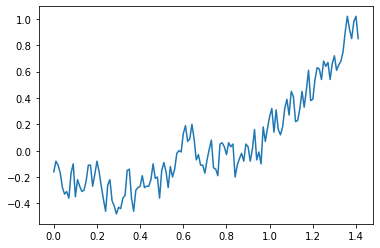

In [13]:
x = torch.tensor(data.iloc[:, 0], dtype=torch.float)
# scale x to a reasonable range
x -= 1880.0
x /= 100.
y_true = torch.tensor(data.iloc[:, 1])
plt.plot(x, y_true)

Create some features that we'll need later; don't worry about this code right now.

In [14]:
feats = torch.stack([x, (x - 0.5).clamp_min(0.0)], axis=1)
f1, f2 = feats.T

## Step 1: Slope Only, MSE

Fit the model `y_pred = weights * x` to the data `x` and `y_true` in a way that minimizes the mean squared error (MSE). Note that there is no intercept, so y_pred is 0.0 when x is 0.0.

Here is the basic outline for computing the gradient of MSE using PyTorch. Fill in the blanks.

Terminology:

- *weights*: the slope of the line
- *loss*: the mean squared error.

You should achieve a loss between 0.09 and 0.11.

Final MSE: 0.091


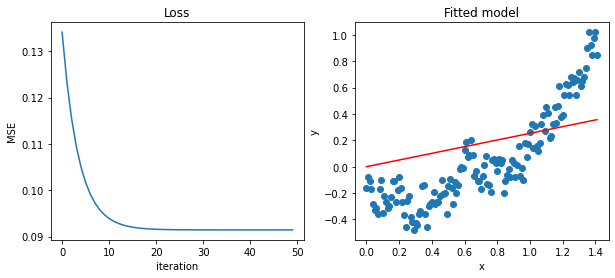

In [22]:
learning_rate = 0.1
weights = torch.tensor([0.0], requires_grad=True)

errors = []

for i in range(50):
    # Forward pass: compute loss
    # y_pred = ...
    y_pred = weights * x
    # resid = ...
    resid = y_true - y_pred
    # mse = ...
    mse = resid.pow(2).mean()
    errors.append(mse.item())

    # Backward pass: compute gradients
    mse.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {errors[-1]:.3f}")

## Step 2: Add bias (intercept)

Now, add a bias term, so you're fitting the model `y_pred = weights * x + bias`. Use the same data and loss function.

Terms:

- *bias*: the intercept of the line

You should get an MSE of between 0.3 and 0.4.

Final MSE: 0.033


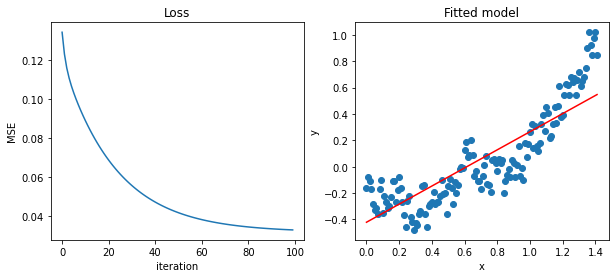

In [23]:
learning_rate = 0.1
weights = torch.tensor([0.0], requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)

errors = []

for i in range(100):
    # Forward pass:
    # y_pred = weights * x + bias
    y_pred = weights * x + bias
    # resid = ...
    resid = y_true - y_pred
    # mse = ...
    mse = resid.pow(2).mean()
    errors.append(mse.item())

    # Backward pass:
    mse.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    # bias.data ...
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {errors[-1]:.3f}")

## Step 3: Change loss function

Now, minimze the Mean Absolute Error (mean of abs(resid)) instead of the MSE. Use the same model `y_pred = weights * x + bias` and data.

You should get an MAE of between 0.6 and 0.7.

*You may want to rename the variable used for the loss to `loss`*.

Final loss: 0.148


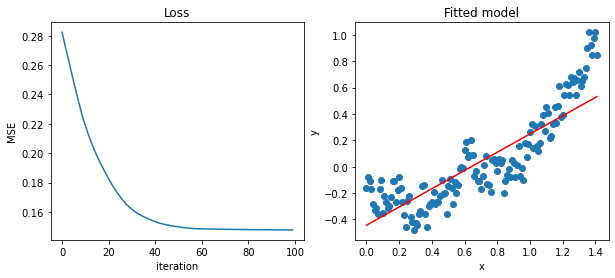

In [24]:
learning_rate = 0.1
weights = torch.tensor([0.0], requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)

errors = []

for i in range(100):
    # Forward pass:
    # y_pred = weights * x + bias
    y_pred = weights * x + bias
    # resid = ...
    resid = y_true - y_pred
    # mae = ...
    mae = resid.abs().mean()
    errors.append(mae.item())

    # Backward pass:
    mae.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    # bias.data ...
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final loss: {errors[-1]:.3f}")

## Step 4: Multiple linear regression

Note that the data has a corner in it near the middle. Ideally rather than fitting a line, we should fit a model that can add a "going down" segment.

We can actually do this using linear regression in the same way as we did before. We can think of linear regression as mixing together some functions. In Steps 2 and 3 we mixed together two functions: an "always going up" function for x and a flat function, i.e., $f_1(x) = x$ and $f_2(x) = 1.0$.

Let's add another function into the mix. The easiest way to describe it is to see it:

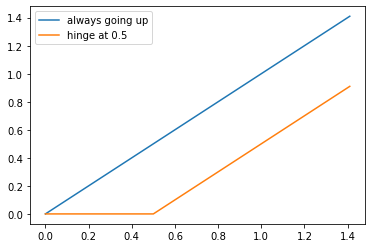

In [25]:
plt.plot(x, f1, label="always going up")
plt.plot(x, f2, label="hinge at 0.5")
plt.legend();

Why might that help us? Well, we can mix them together. Try adjusting the mixing weights to fit the data.

In [28]:
@widgets.interact(w1=(-10.0, 10.0), w2=(-10.0, 10.0), bias=(-1.0, 1.0))
def plot_linreg(w1, w2, bias):
    y_pred = w1 * f1 + w2 * f2 + bias
    plt.scatter(x, y_true)
    plt.plot(x, y_pred, 'r')
    resid = y_true - y_pred
    mse = resid.pow(2).mean()
    mae = resid.abs().mean()
    print(f"MSE: {mse}, MAE: {mae}")

interactive(children=(FloatSlider(value=0.0, description='w1', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

Now, fit the model `y_pred = w1 * f1 + w2 * f2 + bias`. Use MSE loss and the same data.

You should get an MSE of between 0.7 and 0.8.

> There are two ways to do this:
>
> 1. Make a `tensor` for `w1` and another tensor for `w2`, then use the `y_pred` expression above.
> 2. Add a second item to `weights`, and use `feats @ weights`... why does this work?

In [29]:
feats.shape, weights.shape

(torch.Size([142, 2]), torch.Size([1]))

Final MSE: 0.019


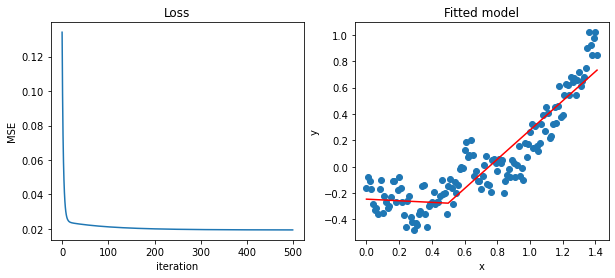

In [30]:
learning_rate = 0.5
weights = torch.tensor([0.0, 0.0], requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)

errors = []

for i in range(500):
    # Forward pass:
    y_pred = feats @ weights + bias
    # resid = ...
    resid = y_true - y_pred
    # mse = ...
    mse = resid.pow(2).mean()
    errors.append(mse.item())

    # Backward pass:
    mse.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    # bias.data ...
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {errors[-1]:.3f}")

In [31]:
weights, bias

(tensor([-0.0611,  1.1706], requires_grad=True),
 tensor(-0.2465, requires_grad=True))